# Hyperparameter Optimization

This is the last notebook of this project. Here I'll try to squeeze a little more AUC from LightGBM by tweaking its hyperparameters. I'll use Bayesian Search here, as it usually performs better than Random or Grid Search.

In [9]:
from functools import partial
from sklearn import ensemble, metrics, model_selection
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
import gc
from imports import *

In [64]:
df=pd.read_csv('../data/train_fs.csv')
df=convert_types(df)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,WALLSMATERIAL_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_YEAR,previous_CHANNEL_TYPE_Channelofcorporatesales_mean,previous_CODE_REJECT_REASON_HC_mean,previous_PRODUCT_COMBINATION_CashStreetlow_mean,previous_NAME_YIELD_GROUP_low_action_mean,previous_PRODUCT_COMBINATION_CashStreethigh_mean,previous_CHANNEL_TYPE_APCashloan_mean,previous_NAME_PRODUCT_TYPE_walkin_mean,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_mean,previous_PRODUCT_COMBINATION_CashXSellhigh_mean,previous_NAME_CONTRACT_STATUS_Refused_mean,previous_NAME_GOODS_CATEGORY_Furniture_mean,previous_NAME_SELLER_INDUSTRY_Furniture_mean,previous_PRODUCT_COMBINATION_POSindustrywithinterest_mean,previous_PRODUCT_COMBINATION_CashXSelllow_mean,previous_NAME_SELLER_INDUSTRY_XNA_mean,previous_NAME_TYPE_SUITE_Unaccompanied_mean,previous_NAME_YIELD_GROUP_middle_mean,previous_NAME_CLIENT_TYPE_New_mean,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_NAME_YIELD_GROUP_high_mean,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_GOODS_PRICE_min,previous_DAYS_FIRST_DRAWING_mean,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_min_max,client_cash_SK_DPD_mean_min,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_NAME_CONTRACT_STATUS_Completed_mean_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_min,client_cash_SK_DPD_DEF_mean_mean,client_cash_SK_DPD_mean_mean,client_cash_NAME_CONTRACT_STATUS_Active_mean_mean,client_cash_NAME_CONTRACT_STATUS_Completed_sum_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_max,client_cash_CNT_INSTALMENT_FUTURE_sum_min,client_cash_NAME_CONTRACT_STATUS_Active_sum_mean,client_cash_CNT_INSTALMENT_min_mean,client_cash_NAME_CONTRACT_STATUS_Active_mean_sum,client_cash_CNT_INSTALMENT_FUTURE_mean_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_credit_MONTHS_BALANCE_sum_sum,client_credit_AMT_RECIVABLE_min_min,client_credit_AMT_DRAWINGS_POS_CURRENT_sum_min,client_credit_AMT_DRAWINGS_POS_CURRENT_sum_su

In [85]:
def optimize(params, x, y, k=5):
    global ITERATION
    ITERATION += 1
    aucs_test=[]
    subsample = params['boosting_type'].get('subsample', 1.0)
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    params['metrics']='auc'
    params['verbose']=-1
    for p in ['num_leaves', 'max_depth', 'min_child_samples']:
        params[p] = int(params[p])

    start = timer()
    kfold=StratifiedKFold(k)
    for f, (tr, te) in enumerate(kfold.split(x, y=y)):
        X_train, y_train=x.iloc[tr, :], y.iloc[tr]
        X_test, y_test=x.iloc[te, :], y.iloc[te]

        params=params
        dtrain=lgb.Dataset(X_train, label=y_train)
        dval=lgb.Dataset(X_test, label=y_test)
   
        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(100, verbose=-100), lgb.log_evaluation(-100)],
                categorical_feature=list(x.select_dtypes(include=['category', 'object']).columns),
                verbose_eval=False)
        
        aucs_test.append(model.best_score['test']['auc'])

    run_time = timer() - start
    
    auc_mean=np.mean(aucs_test)
    return {'loss': 1-auc_mean, 'auc': auc_mean, 'params': params, 'iteration': ITERATION,
                'train_time': run_time, 'status': STATUS_OK}

In [86]:
df_sample=df.sample(frac=.3)

In [ ]:
X, y=df.drop(['TARGET'], axis=1), df['TARGET'].astype(int)

param_space = {
    'boosting_type': hp.choice('boosting_type', 
                    [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.6, 1)}, 
                     {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.6, 1)},
                     {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 18, 2),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

# t=Trials()
ITERATION, MAX_EVALS=252, 280

hopt=fmin(
    fn=partial(optimize, x=X, y=y),
    space=param_space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=t
)

hopt

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[100]	train's auc: 0.815374	test's auc: 0.768914
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[100]	train's auc: 0.815345	test's auc: 0.76928
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[100]	train's auc: 0.815997	test's auc: 0.762156
Training until validation scores don't improve for 100 rounds                                                          
Did not meet e

In [137]:
res=pd.DataFrame()
params_list=[exp['params'] for exp in t.results]

for i in ['iteration', 'loss', 'auc']:
    res[i]=[exp[i] for exp in t.results]
    
for n, p in enumerate(params_list):
    for k,v in p.items():
        res.loc[n, k]=v
        
res.sort_values('loss').head(10)

,iteration,loss,auc,boosting_type,colsample_bytree,is_unbalance,learning_rate,max_depth,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,metrics,verbose
48,49,0.22665,0.77335,goss,0.80338,False,0.05896,12.00000,340.00000,80.00000,0.47484,0.86293,1.00000,auc,-1.00000
66,67,0.22670,0.77330,goss,0.80564,False,0.05812,16.00000,390.00000,106.00000,0.32873,0.51633,1.00000,auc,-1.00000
190,192,0.22690,0.77310,goss,0.62987,True,0.05349,12.00000,300.00000,141.00000,0.45215,0.50406,1.00000,auc,-1.00000
88,89,0.22696,0.77304,goss,0.72524,True,0.07239,16.00000,285.00000,76.00000,0.17574,0.94538,1.00000,auc,-1.00000
195,197,0.22696,0.77304,goss,0.63642,True,0.06482,12.00000,305.00000,120.00000,0.74245,0.50435,1.00000,auc,-1.00000
220,222,0.22701,0.77299,goss,0.73645,True,0.07491,12.00000,285.00000,50.00000,0.99305,0.33337,1.00000,auc,-1.00000
126,128,0.22707,0.77293,gbdt,0.79460,False,0.07782,18.00000,500.00000,64.00000,0.03869,0.83790,0.91583,auc,-1.00000
97,98,0.22708,0.77292,goss,0.68102,True,0.08312,14.00000,330.00000,63.00000,0.21037,0.92687,1.00000,auc,-1.00000
162,164,0.22711,0.77289,gbdt,0.72248,True,0.06648,16.00000,280.00000,70.00000,0.57946,0.99592,0.85268,auc,-1.00000
200,202,0.22714,0.77286,goss,0.62536,True,0.04730,12.00000,370.00000,139.00000,0.36676,0.47062,1.00000,auc,-1.00000


In [117]:
import json

trials_dict=sorted(t.results, key = lambda x: x['loss'])
with open('../data/trials.bin', 'w') as f:
    f.write(json.dumps(trials_dict))

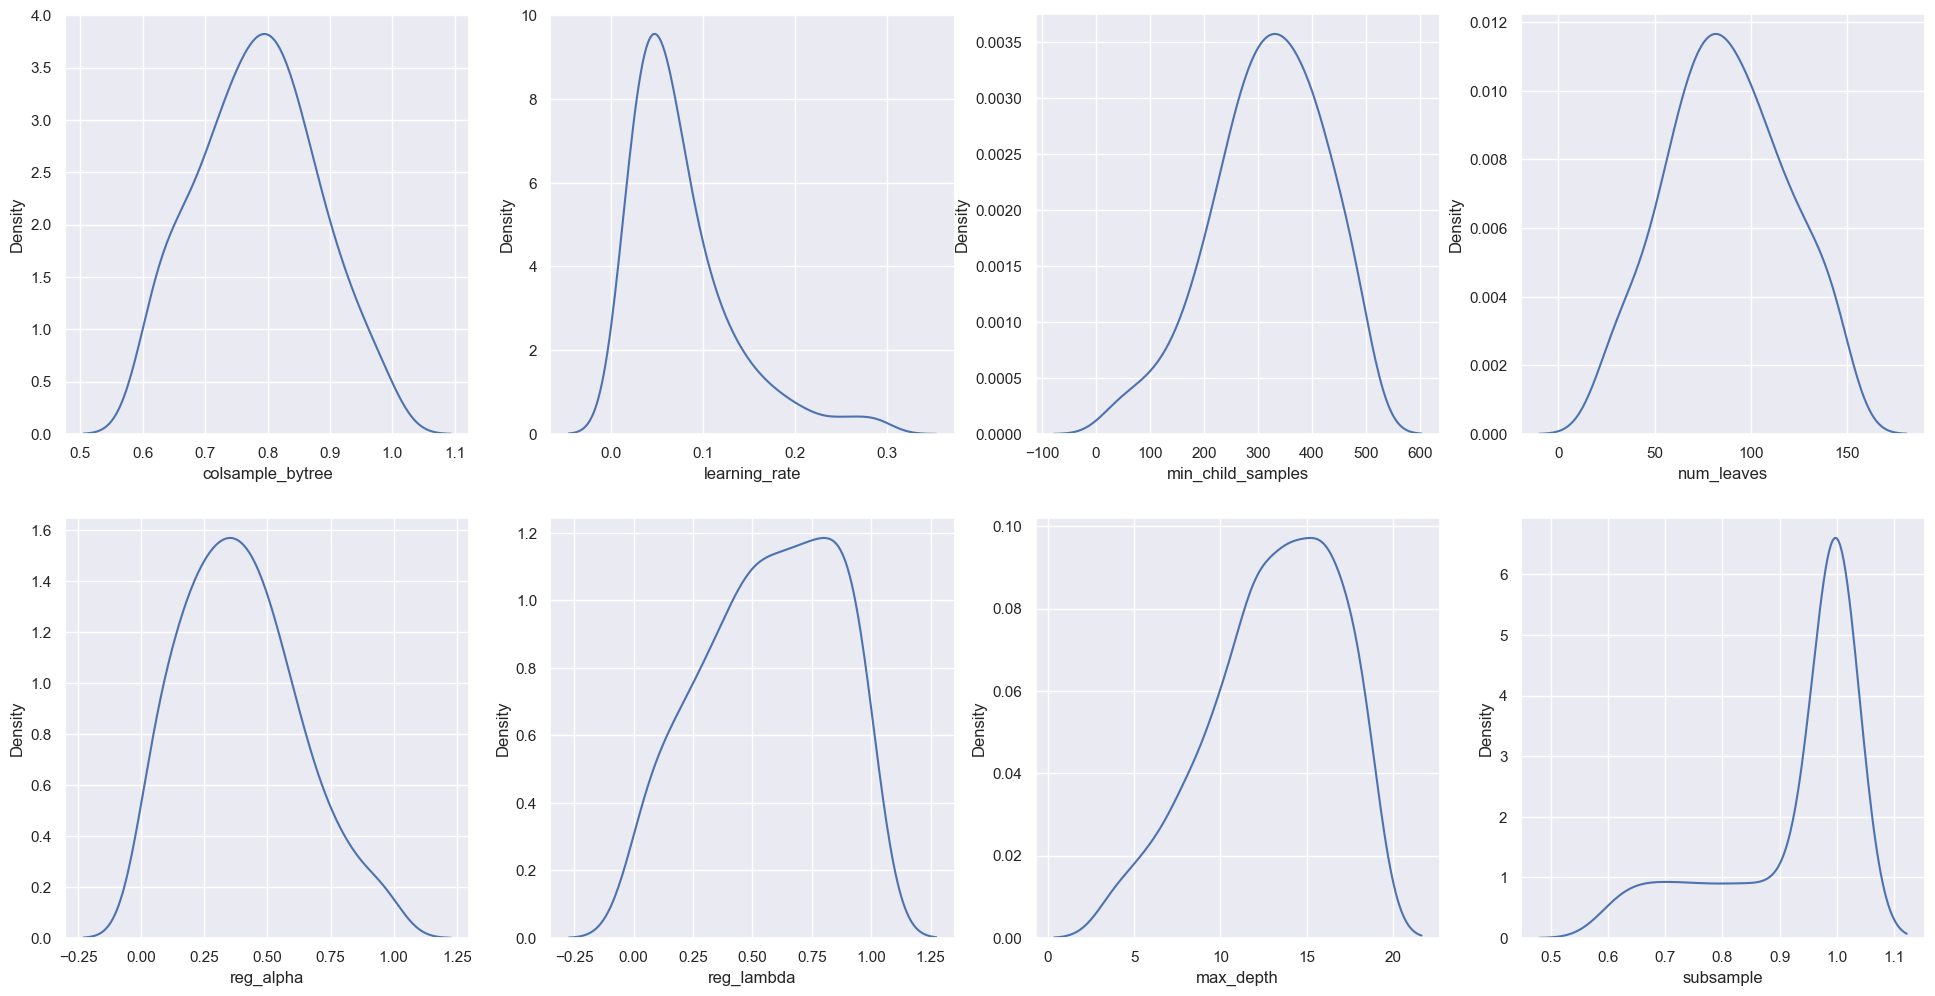

In [164]:
fig, axs = plt.subplots(2, 4, figsize = (24, 12))


for c, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves',
                              'reg_alpha', 'reg_lambda', 'max_depth', 'subsample']):
        sns.kdeplot(x=hyper, data=res, ax=axs[c//4, c%4])


In [167]:
res.iloc[99:]

,iteration,loss,auc,boosting_type,colsample_bytree,is_unbalance,learning_rate,max_depth,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,metrics,verbose
99,100,0.23079,0.76921,dart,0.60801,True,0.13556,16.00000,280.00000,76.00000,0.18305,0.67884,0.96368,auc,-1.00000
100,102,0.22830,0.77170,goss,0.78407,True,0.05164,10.00000,220.00000,71.00000,0.67293,0.74528,1.00000,auc,-1.00000
101,103,0.23344,0.76656,goss,0.67019,True,0.02984,14.00000,345.00000,58.00000,0.05192,0.83490,1.00000,auc,-1.00000
102,104,0.23033,0.76967,goss,0.69004,True,0.03691,18.00000,290.00000,83.00000,0.08824,0.16504,1.00000,auc,-1.00000
103,105,0.22759,0.77241,gbdt,0.73132,True,0.07457,12.00000,245.00000,54.00000,0.58506,0.86710,0.97077,auc,-1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,247,0.23143,0.76857,goss,0.71416,True,0.11904,14.00000,265.00000,84.00000,0.76960,0.62575,1.00000,auc,-1.00000
246,248,0.23988,0.76012,goss,0.78776,False,0.01929,12.00000,195.00000,71.00000,0.31239,0.79141,1.00000,auc,-1.00000
247,249,0.22772,0.77228,goss,0.75515,True,0.09296,8.00000,225.00000,41.00000,0.21404,0.51686,1.00000,auc,-1.00000
248,250,0.23864,0.76136,dart,0.64496,False,0.04272,16.00000,355.00000,63.00000,0.34395,0.29967,0.93409,auc,-1.00000


In [173]:
t.results

[{'loss': 0.2395270882994801,
  'auc': 0.7604729117005199,
  'params': {'boosting_type': 'dart',
   'colsample_bytree': 0.6247783113860637,
   'is_unbalance': False,
   'learning_rate': 0.2876698996815331,
   'max_depth': 12,
   'min_child_samples': 405,
   'num_leaves': 120,
   'reg_alpha': 0.7498392776468238,
   'reg_lambda': 0.18946747110284168,
   'subsample': 0.822834144415607,
   'metrics': 'auc',
   'verbose': -1},
  'iteration': 1,
  'train_time': 92.5742437000008,
  'status': 'ok'},
 {'loss': 0.23497803460358013,
  'auc': 0.7650219653964199,
  'params': {'boosting_type': 'dart',
   'colsample_bytree': 0.6638882599830617,
   'is_unbalance': True,
   'learning_rate': 0.05272000148128563,
   'max_depth': 14,
   'min_child_samples': 475,
   'num_leaves': 85,
   'reg_alpha': 0.20453443643899838,
   'reg_lambda': 0.05803062749011434,
   'subsample': 0.6857377389521335,
   'metrics': 'auc',
   'verbose': -1},
  'iteration': 2,
  'train_time': 84.38431349999155,
  'status': 'ok'},
 {'